# 2023 F1 Season Analysis

This notebook computes extended F1 metrics and visualizes driver comparisons.

## Setup

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from math import pi



# Display settings
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = (8, 6)

# Ergast API base URL
BASE = "https://api.jolpi.ca/ergast/f1/"


ModuleNotFoundError: No module named 'requests'

## 1. Fetch Race Schedule

In [ ]:
def fetch_races(year):
    url = f"{BASE}/{year}.json"
    try:
        resp = requests.get(url)
        resp.raise_for_status()
        races = resp.json()['MRData']['RaceTable']['Races']
        df = pd.DataFrame(races)[['round','raceName','date','Circuit']].copy()
        df['Circuit'] = df['Circuit'].apply(lambda c: c['circuitName'])
        return df.set_index('round')
    except requests.exceptions.RequestException as e:
        print(f"Error fetching race data: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

races_df = fetch_races(2023)
races_df

,raceName,date,Circuit
round,,,
1,Bahrain Grand Prix,2023-03-05,Bahrain International Circuit
2,Saudi Arabian Grand Prix,2023-03-19,Jeddah Corniche Circuit
3,Australian Grand Prix,2023-04-02,Albert Park Grand Prix Circuit
4,Azerbaijan Grand Prix,2023-04-30,Baku City Circuit
5,Miami Grand Prix,2023-05-07,Miami International Autodrome
6,Monaco Grand Prix,2023-05-28,Circuit de Monaco
7,Spanish Grand Prix,2023-06-04,Circuit de Barcelona-Catalunya
8,Canadian Grand Prix,2023-06-18,Circuit Gilles Villeneuve
9,Austrian Grand Prix,2023-07-02,Red Bull Ring


## 2. Fetch Qualifying & Race Results

In [ ]:
def fetch_results(year, rnd, session):
    url = f"{BASE}/{year}/{rnd}/{session}.json?limit=50"
    resp = requests.get(url); resp.raise_for_status()
    data = resp.json()['MRData']['RaceTable']['Races']
    if not data: return []
    key = 'Results' if session=='results' else 'QualifyingResults'
    results = data[0].get(key, [])
    for r in results: r['round'] = int(rnd)
    return results

qual_list, race_list = [], []
for rnd in races_df.index:
    qual_list += fetch_results(2023, rnd, 'qualifying')
    race_list += fetch_results(2023, rnd, 'results')

qual_df = pd.json_normalize(qual_list)
race_df = pd.json_normalize(race_list)
qual_df['position'] = qual_df['position'].astype(int)
race_df['position'] = race_df['position'].astype(int)
race_df['points'] = race_df['points'].astype(float)


## 3. Compute Extended Metrics

In [ ]:
# Map driverId to full name
drivers = qual_df['Driver.driverId'].unique()
driver_names = {
    d: f"{qual_df.loc[qual_df['Driver.driverId']==d, 'Driver.givenName'].iloc[0]} "
       f"{qual_df.loc[qual_df['Driver.driverId']==d, 'Driver.familyName'].iloc[0]}"
    for d in drivers
}

# Compute Qualifying delta vs teammate
delta_q = {}
for d in drivers:
    deltas = []
    df_d = qual_df[qual_df['Driver.driverId']==d]
    for _, row in df_d.iterrows():
        rnd = row['round']; team = row['Constructor.constructorId']
        peer = qual_df[(qual_df['round']==rnd)&
                       (qual_df['Constructor.constructorId']==team)&
                       (qual_df['Driver.driverId']!=d)]
        if len(peer)==1:
            deltas.append(row['position'] - peer.iloc[0]['position'])
    delta_q[d] = np.mean(deltas) if deltas else np.nan

# Assemble stats
stats = []
for d in drivers:
    q = qual_df[qual_df['Driver.driverId']==d]['position']
    r = race_df[race_df['Driver.driverId']==d]['position']
    pts = race_df[race_df['Driver.driverId']==d]['points']
    dnfs = (race_df[race_df['Driver.driverId']==d]['status']!='Finished').sum()
    fl = (race_df[race_df['Driver.driverId']==d]['FastestLap.rank']=='1').sum()
    stats.append({
        'Driver':           driver_names[d],
        'Races':            len(r),
        'Avg Grid':         q.mean(),
        'Qual Delta vs TM': delta_q[d],
        'Avg Finish':       r.mean(),
        'Avg Points':       pts.mean(),
        'Podiums':          (r<=3).sum(),
        'DNFs':             dnfs,
        'Fastest Laps':     fl
    })

stats_df = pd.DataFrame(stats).set_index('Driver')
stats_df = stats_df.round(2)
stats_df.sort_values('Avg Finish')

,Races,Avg Grid,Qual Delta vs TM,Avg Finish,Avg Points,Podiums,DNFs,Fastest Laps
Driver,,,,,,,,
Max Verstappen,22,3.00,-6.05,1.27,24.09,21,0,9
Sergio Pérez,22,9.05,6.05,5.86,11.82,9,3,2
Lewis Hamilton,22,6.36,-0.14,6.18,9.86,6,2,4
Fernando Alonso,22,7.00,-5.45,6.64,9.00,8,2,1
Carlos Sainz,22,5.36,0.91,7.50,8.09,3,2,0
Lando Norris,22,8.14,-1.73,8.00,8.36,7,4,1
George Russell,22,6.50,0.14,8.09,7.14,2,3,1
Charles Leclerc,22,4.45,-0.91,8.23,8.41,6,5,0
Pierre Gasly,22,11.05,-0.14,10.68,2.45,1,1,0


## 4. Extended Performance Table

In [ ]:
# Style the table with gradients and bars
styled = stats_df.style \
    .background_gradient(subset=['Avg Grid','Avg Finish'], cmap='Greens') \
    .background_gradient(subset=['Qual Delta vs TM'], cmap='Blues') \
    .background_gradient(subset=['Avg Points'], cmap='Blues') \
    .bar(subset=['Podiums','Fastest Laps','DNFs'], color='#FAB') \
    .highlight_null(color='lightgray')
styled

,Races,Avg Grid,Qual Delta vs TM,Avg Finish,Avg Points,Podiums,DNFs,Fastest Laps
Driver,,,,,,,,
Max Verstappen,22,3.000000,-6.090000,1.270000,24.090000,21,0,9
Sergio Pérez,22,9.090000,6.090000,5.860000,11.820000,9,3,2
Charles Leclerc,22,4.450000,-0.910000,8.230000,8.410000,6,5,0
Carlos Sainz,22,5.360000,0.910000,7.500000,8.090000,3,3,0
Fernando Alonso,22,7.000000,-5.450000,6.640000,9.000000,8,2,1
George Russell,22,6.500000,0.140000,8.090000,7.140000,2,4,1
Lewis Hamilton,22,6.360000,-0.140000,6.180000,9.860000,6,2,4
Lance Stroll,22,12.450000,5.450000,11.180000,3.090000,0,6,0
Esteban Ocon,22,11.180000,0.140000,11.860000,2.550000,1,9,0


## 5. Hexagonal Radar Plot (with Units)

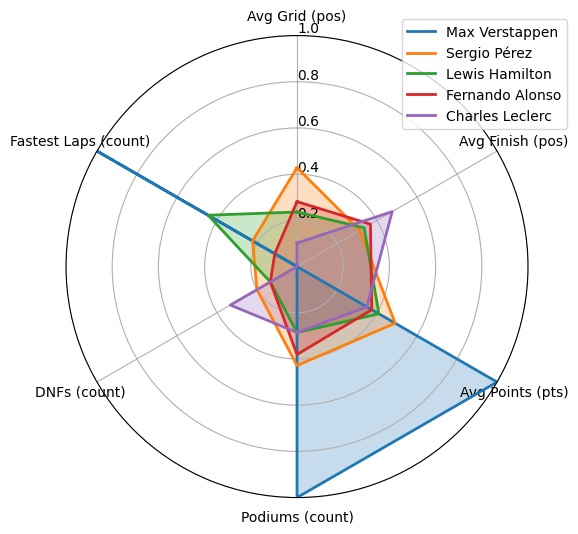

In [ ]:
def plot_hexagon(df, drivers):
    # Define fields and labels with units
    metrics = ['Avg Grid','Avg Finish','Avg Points','Podiums','DNFs','Fastest Laps']
    labels = ['Avg Grid (pos)','Avg Finish (pos)','Avg Points (pts)','Podiums (count)','DNFs (count)','Fastest Laps (count)']
    N = len(metrics)
    # Compute angles
    angles = [n/float(N)*2*pi for n in range(N)] + [0]

    # Normalize metrics
    scaler = MinMaxScaler()
    norm = pd.DataFrame(scaler.fit_transform(df[metrics]), index=df.index, columns=metrics)

    # Plot
    fig, ax = plt.subplots(subplot_kw={'polar':True})
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], labels)
    ax.set_rlabel_position(0)
    ax.set_ylim(0,1)

    for drv in drivers:
        vals = norm.loc[drv].tolist() + [norm.loc[drv, metrics[0]]]
        ax.plot(angles, vals, linewidth=2, label=drv)
        ax.fill(angles, vals, alpha=0.25)
    plt.legend(bbox_to_anchor=(1.1,1.05))
    plt.show()

# Example: Top Amount by Avg Points
topamount = stats_df.nlargest(5,'Avg Points').index.tolist()
plot_hexagon(stats_df, topamount)

## 6. Similarity Heatmap

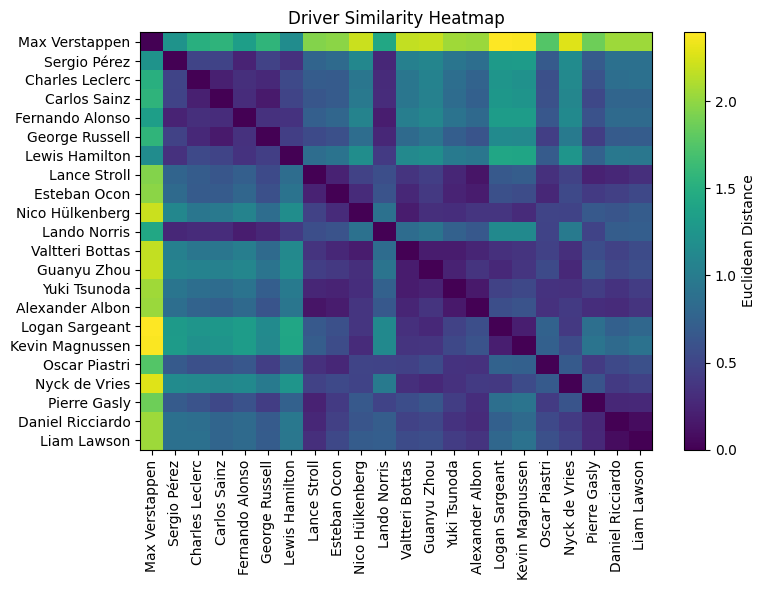

In [ ]:
# Based on extended metrics
M = stats_df[['Avg Grid','Avg Finish','Avg Points','Podiums','DNFs','Fastest Laps']].dropna()
normed = MinMaxScaler().fit_transform(M)
dist = squareform(pdist(normed))
sim = pd.DataFrame(dist, index=M.index, columns=M.index)

plt.imshow(sim, aspect='auto')
plt.colorbar(label='Euclidean Distance')
plt.xticks(range(len(sim)), sim.columns, rotation=90)
plt.yticks(range(len(sim)), sim.index)
plt.title('Driver Similarity Heatmap')
plt.tight_layout()
plt.show()